# Claudia SNSClassification
Output standard non-standard labels for whats the potential of a baby to have downsyndrome. 

In [1]:
# !pip install openpyxl pycocotools faster-coco-eval torchmetrics[detection] pandas matplotlib tqdm opencv-python cuda-python torchvision 
# !pip install scikit-learn
# !pip install openpyxl
# !pip install pandas
# !pip install tf_explain


In [2]:
# !conda install pytorch torchvision cudatoolkit=10.1 -c pytorch


## Imports

In [4]:
# clear_output()

In [21]:

import torch
from IPython.display import clear_output
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import os
from sklearn.model_selection import train_test_split



In [22]:
torch.cuda.is_available()

True

## Preparing the Dataset


In [23]:

# Function to load images and their labels
def load_images_and_labels(standard_path, nonstandard_path):
    image_paths = []
    labels = []  # 1 for Standard, 0 for Non-standard

    # Load Non-standard images
    for img_name in os.listdir(nonstandard_path):
        img_path = os.path.join(nonstandard_path, img_name)
        if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(img_path)
            labels.append(0)  # Non-standard label

    # Load Standard images
    for img_name in os.listdir(standard_path):
        img_path = os.path.join(standard_path, img_name)
        if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(img_path)
            labels.append(1)  # Standard label

    return image_paths, labels

# Define the Dataset class with conditional transformations
class FetalUltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, transform_nonstandard=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.transform_nonstandard = transform_nonstandard

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if label == 0 and self.transform_nonstandard:
            image = self.transform_nonstandard(image)
        elif self.transform:
            image = self.transform(image)

        return image, label


## Load image paths and labels


In [24]:

standard_path = "./allStandard/allStandard"
nonstandard_path = "./allNonStandard"
image_paths, labels = load_images_and_labels(standard_path, nonstandard_path)
print(f"Total images loaded: {len(image_paths)}")


Total images loaded: 1684


## Seperate images (perform data augmentations for train + validation)

In [25]:
def separate_images(image_paths, labels):
    standard_images = [img for img, label in zip(image_paths, labels) if label == 1]
    nonstandard_images = [img for img, label in zip(image_paths, labels) if label == 0]
    return standard_images, nonstandard_images

standard_images, nonstandard_images = separate_images(image_paths, labels)
print(f"Number of standard images: {len(standard_images)}")
print(f"Number of non-standard images: {len(nonstandard_images)}")

# Split for test sets (15%)
standard_train, standard_test = train_test_split(standard_images, test_size=0.15, random_state=42)
nonstandard_train, nonstandard_test = train_test_split(nonstandard_images, test_size=0.15, random_state=42)

# Combine for full test set
test_images = standard_test + nonstandard_test   #this should have no augmentations done to it 
test_labels = [1] * len(standard_test) + [0] * len(nonstandard_test)


Number of standard images: 1197
Number of non-standard images: 487


In [26]:
## AUGMENTATIONS on NON STANDARD 

# Augment non-standard images to balance sizes
augmented_nonstandard = []
augment_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=25),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for path in nonstandard_train:
    image = Image.open(path).convert('RGB')
    for _ in range((len(standard_train) // len(nonstandard_train)) + 1):  # Augment to balance
        augmented_image = augment_transforms(image)
        augmented_nonstandard.append((augmented_image, 0))  # Store as a tuple of (image, label)


In [48]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split



# Combine and split remaining train and validation sets 
all_train_images = standard_train + [x[0] for x in augmented_nonstandard]
all_train_labels = [1] * len(standard_train) + [0] * len(augmented_nonstandard)

print(len(all_train_images), len(all_train_labels))


train_images, val_images, train_labels, val_labels = train_test_split(
    all_train_images, all_train_labels, test_size=0.2, random_state=42)

print(len(train_images), len(val_images))
# # Add other necessary imports and class definitions (like FetalUltrasoundDataset)

# # Split data
# image_paths_train, image_paths_temp, labels_train, labels_temp = train_test_split(
#     image_paths, labels, test_size=0.3, random_state=42)

# image_paths_val, image_paths_test, labels_val, labels_test = train_test_split(
#     image_paths_temp, labels_temp, test_size=0.5, random_state=42)


# Transformations for the training data with augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=25),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transformations for the validation and test data without augmentation
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = FetalUltrasoundDataset(image_paths_train, labels_train, transform=train_transforms)
val_dataset = FetalUltrasoundDataset(image_paths_val, labels_val, transform=eval_transforms)
test_dataset = FetalUltrasoundDataset(image_paths_test, labels_test, transform=eval_transforms)


# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Now you can use these loaders in your model training and evaluation routines.


2256 2256
1804 452


In [50]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


## Train Function

In [53]:

# Training function
def train_model(model, data_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in data_loader:

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


## Evaluate Function

loss function and optimizer

In [66]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total = correct = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Optionally, plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Standard', 'Standard'], yticklabels=['Non-Standard', 'Standard'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


### Methodology 1 : Freeze all retrain last layer 

## Iteration 1: Resnet18 + Batchsize 32

In [52]:

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model = model.to(device)


# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [54]:
train_model(model, train_loader, criterion, optimizer)


Epoch 1/10, Loss: 0.6048
Epoch 2/10, Loss: 0.3377
Epoch 3/10, Loss: 0.3540
Epoch 4/10, Loss: 0.3391
Epoch 5/10, Loss: 0.3412
Epoch 6/10, Loss: 0.2899
Epoch 7/10, Loss: 0.3132
Epoch 8/10, Loss: 0.3001
Epoch 9/10, Loss: 0.2613
Epoch 10/10, Loss: 0.2652


In [56]:
## For test 
evaluate_model(model, val_loader)
evaluate_model(model, test_loader)

Accuracy: 69.57%
Accuracy: 71.54%


## Iteration 2: Resnet 34 + Batchsize 32

In [58]:

# Load a pretrained ResNet model and modify it for binary classification
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer)


Epoch 1/10, Loss: 0.5925
Epoch 2/10, Loss: 0.3931
Epoch 3/10, Loss: 0.3579
Epoch 4/10, Loss: 0.3258
Epoch 5/10, Loss: 0.3300
Epoch 6/10, Loss: 0.3288
Epoch 7/10, Loss: 0.3265
Epoch 8/10, Loss: 0.3186
Epoch 9/10, Loss: 0.3016
Epoch 10/10, Loss: 0.2714


In [59]:
## For test 
evaluate_model(model, val_loader)
evaluate_model(model, test_loader)

Accuracy: 75.89%
Accuracy: 69.17%


## Iteration 3: RESNET 34 + Batchsize 64

In [61]:

# Creating data loaders
train_loader_64 = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_64 = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_64 = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [62]:

# Load a pretrained ResNet model and modify it for binary classification
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer)


Epoch 1/10, Loss: 0.6033
Epoch 2/10, Loss: 0.4110
Epoch 3/10, Loss: 0.3939
Epoch 4/10, Loss: 0.3390
Epoch 5/10, Loss: 0.3330
Epoch 6/10, Loss: 0.3037
Epoch 7/10, Loss: 0.2977
Epoch 8/10, Loss: 0.3154
Epoch 9/10, Loss: 0.3110
Epoch 10/10, Loss: 0.3234


Accuracy: 88.54%
Confusion Matrix:
[[ 46  19]
 [ 10 178]]


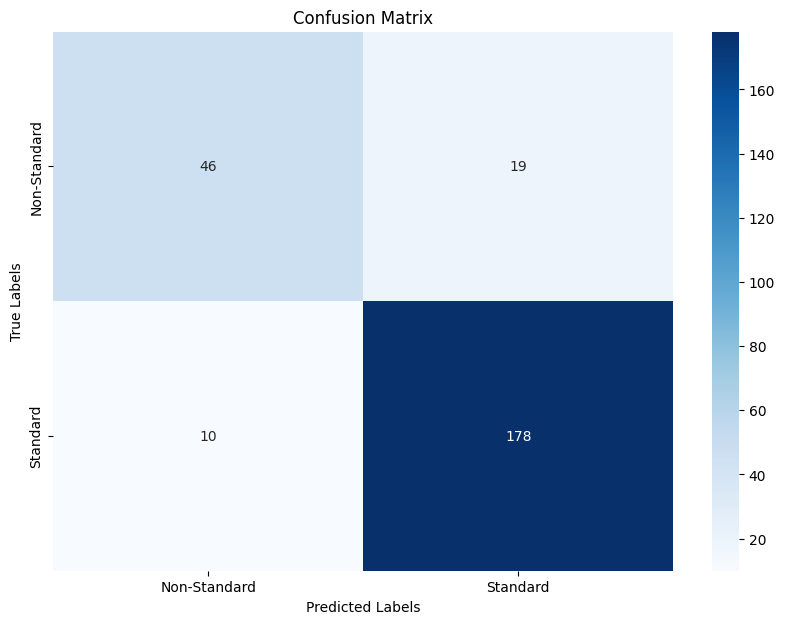

Accuracy: 89.33%
Confusion Matrix:
[[ 62  19]
 [  8 164]]


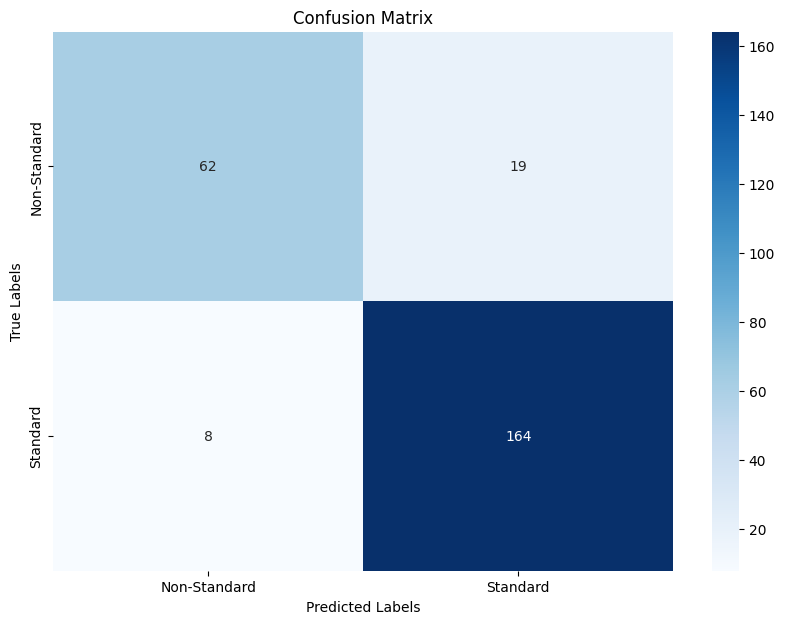

In [67]:
## For test 
evaluate_model(model, val_loader)
evaluate_model(model, test_loader)

## Iteration 4: RESNET 18 + Batchsize 64


In [69]:

# Load a pretrained ResNet model and modify it for binary classification
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer)


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.5838
Epoch 2/10, Loss: 0.3778
Epoch 3/10, Loss: 0.3570
Epoch 4/10, Loss: 0.3353
Epoch 5/10, Loss: 0.3092
Epoch 6/10, Loss: 0.2879
Epoch 7/10, Loss: 0.2920
Epoch 8/10, Loss: 0.2942
Epoch 9/10, Loss: 0.2938
Epoch 10/10, Loss: 0.2569


Accuracy: 88.54%
Confusion Matrix:
[[ 61   4]
 [ 25 163]]


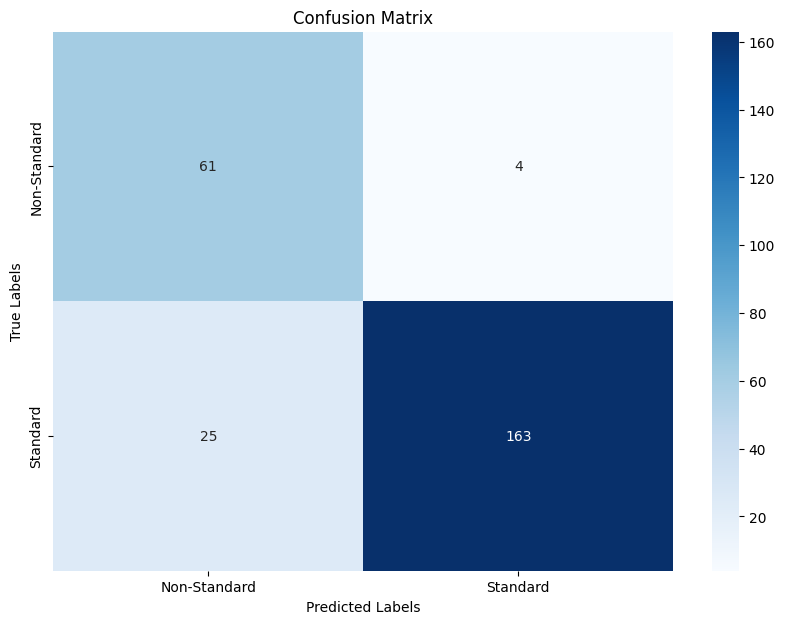

Accuracy: 85.77%
Confusion Matrix:
[[ 79   2]
 [ 34 138]]


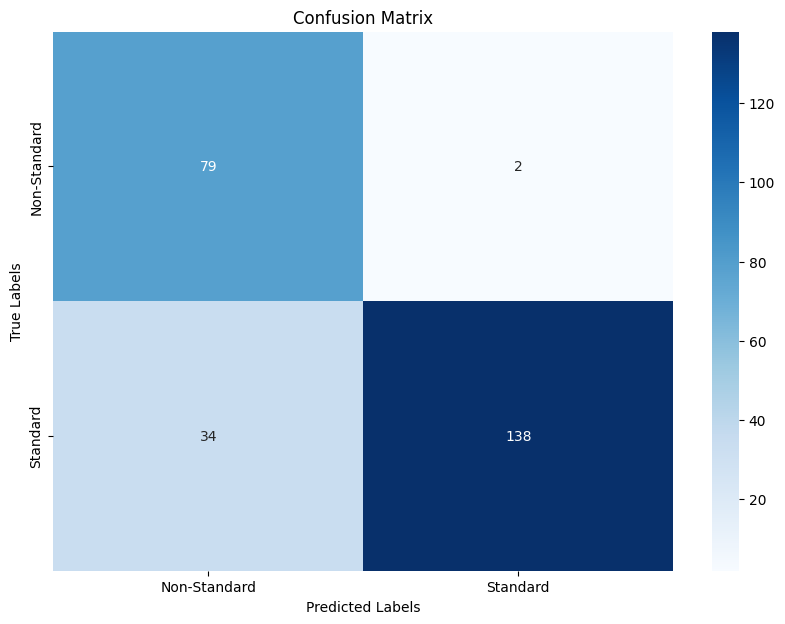

In [70]:
## For test 
evaluate_model(model, val_loader)
evaluate_model(model, test_loader)

## Iteration 5: RESNET 50 + Batchsize 64


In [ ]:

# Load a pretrained ResNet model and modify it for binary classification
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer)


In [ ]:
## For test 
evaluate_model(model, val_loader, criterion)
evaluate_model(model, test_loader, criterion)

In [ ]:
## 

### Methodology 2: Freeze all retrain last layer 
epochs 15
LR 0.001


## Iteration 6: RESNET 50 + Batchsize 64
